<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we will build up a Gaussian process for interpolating unstructured data in one dimension. You can use this code as a jumping off point for the BayesOpt question in the upcoming homework assignment.

In [4]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


Here we generate the samples of the true function, together with the set of points where we would like to query the Gaussian process

In [270]:
def true_function(x):
  return tf.exp(-2.0*x**2)*tf.cos(tf.cast(4.*np.pi,tf.float64)*x)

#Experiment 1: just a few points
Ninput = 3
x_input = tf.constant([-0.5,0.1,0.3],dtype=tf.float64)
#Experiment 2: lots of points
# Ninput = 11
# x_input = tf.constant(np.linspace(-1,1,Ninput),dtype=tf.float64)

y_input = true_function(x_input)
x_star = tf.constant(np.linspace(-1,1,101),dtype=tf.float64)

Next we construct the covariance matrices to be used in the schur complement problem. We employ a squared exponential kernel, and zero mean for the prior distribution

In [271]:
Lsq = tf.exp(1.0*tf.Variable(np.log(2.0/Ninput),dtype=tf.float64)) #trainable lengthscale squared for squared exponential kernel
KXX         = tf.exp(-0.5*tf.abs(tf.expand_dims(x_input,0)-tf.expand_dims(x_input,1))**2/Lsq)
KXXstar     = tf.exp(-0.5*tf.abs(tf.expand_dims(x_input,0)-tf.expand_dims(x_star,1) )**2/Lsq)
KXstarX     = tf.exp(-0.5*tf.abs(tf.expand_dims(x_star,0) -tf.expand_dims(x_input,1))**2/Lsq)
KXstarXstar = tf.exp(-0.5*tf.abs(tf.expand_dims(x_star,0) -tf.expand_dims(x_star,1) )**2/Lsq)

muX     = tf.constant(np.zeros(x_input.shape),dtype=tf.float64)
muXstar = tf.constant(np.zeros(x_star.shape),dtype=tf.float64)


Next we evaluate the schur complement mu_star and sigma_star to obtain the parameters of the posterior distribution over xstar

In [272]:
Kinv = tf.linalg.pinv(KXX,rcond=1e-10)
mu_star = muXstar + tf.einsum('ij,jk,k->i',KXXstar,Kinv,y_input-muX)
K_star = KXstarXstar - tf.einsum('ij,jk,kl->il',KXXstar,Kinv,KXstarX)
K_stardiag = tf.linalg.diag_part(K_star)

Finally we build up the MLE problem for calibrating the shape parameter

In [277]:
term1 = -0.5*tf.einsum('i,ij,j',y_input,tf.linalg.pinv(KXX),y_input)
term2 = -0.5*tf.linalg.logdet(KXX)
LOSS_MLE = -(term1+term2)
optimizer_MLE = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(LOSS_MLE)

sess.run(tf.global_variables_initializer()) #initialize model

First, we will plot the posterior distribution of the GP without calibrating the shape parameter

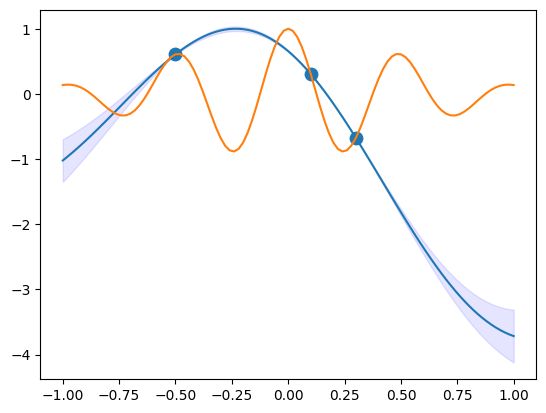

In [278]:
mu_np = sess.run(mu_star)
K_np = np.abs(sess.run(K_stardiag))
plt.scatter(sess.run(x_input),sess.run(y_input),s=80)
plt.plot(sess.run(x_star),mu_np)
plt.plot(sess.run(x_star),sess.run(true_function(x_star)))
plt.fill_between(sess.run(x_star), mu_np-np.sqrt(K_np), mu_np+np.sqrt(K_np),alpha=0.1,color='blue')

In [281]:
for i in range(5000):
  sess.run(optimizer_MLE)
  if i%1000==0:
    print(i,sess.run(LOSS_MLE))

0 0.5736099895651843
1000 0.5202364784861884
2000 0.4913638248426913
3000 0.4661397719938028
4000 0.45967116708673905


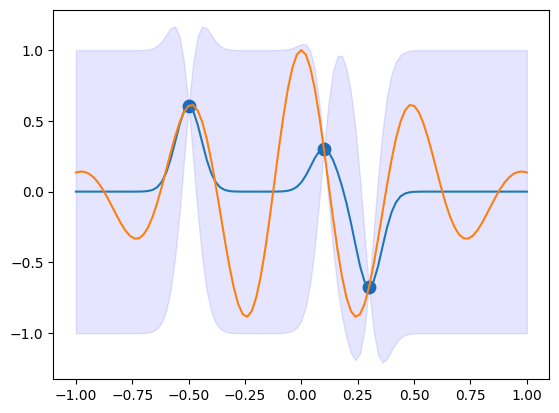

In [282]:
mu_np = sess.run(mu_star)
K_np = sess.run(K_stardiag)
plt.scatter(sess.run(x_input),sess.run(y_input),s=80)
plt.plot(sess.run(x_star),mu_np)
plt.plot(sess.run(x_star),sess.run(true_function(x_star)))
plt.fill_between(sess.run(x_star), mu_np-np.sqrt(K_np), mu_np+np.sqrt(K_np),alpha=0.1,color='blue')